In [8]:
from SOH_func_scaler import *
import matplotlib.pyplot as pl
from keras import models, layers
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import datetime
import os

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [9]:
VERSION = 'Scaler_Norm'

FILE_00 = 'data_csv/CYCLE_CSV_data00.csv'
FILE_01 = 'data_csv/CYCLE_CSV_data01.csv'
FILE_02 = 'data_csv/CYCLE_CSV_data02.csv'
FILE_03 = 'data_csv/CYCLE_CSV_data03.csv'
FILE_04 = 'data_csv/CYCLE_CSV_data04.csv'
FILE_05 = 'data_csv/CYCLE_CSV_data05.csv'
FILE_06 = 'data_csv/CYCLE_CSV_data06.csv'

In [10]:
drop_labels_x = ['인덱스', '사이클_번호', '누적_용량(Ah)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']
drop_labels_y = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '방전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']
# 예측에 사용하지 않을 파라미터 목록

param = {'seq_len' : 30, 'num_units' : 64, 'num_filters' : 6, 'window' : 3, 'dropout': 0.1, 'num_epochs' : 2000, 'num_dense': 16}
# 모델 규격 지정 하이퍼파라미터

log_dir = f"logs/{VERSION}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M") + f'-{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
file_path = f'Checkpoints\{VERSION}\SOH_Checkpoint\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ.h5'
hist_freq = 250
# 텐서보드 설정(logs 폴더에 모델 학습 기록 저장)

save_path = f'outputs\{VERSION}\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
try:
    if not os.path.exists(save_path):
        os.makedirs(save_path)
except OSError:
    print('Error Creating Directory...')
# 출력 저장 폴더 생성

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data00.csv => (475, 4)


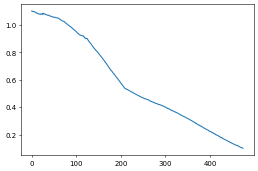

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data02.csv => (515, 4)


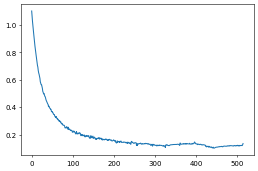

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data05.csv => (515, 4)


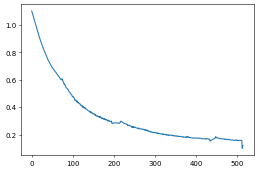

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data04.csv => (515, 4)


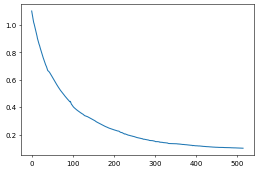

In [11]:
data00, data_cap00 = get_data(FILE_00, drop_labels_x, drop_labels_y)
# data01, data_cap01 = get_data(FILE_01, drop_labels_x, drop_labels_y)
data02, data_cap02 = get_data(FILE_02, drop_labels_x, drop_labels_y)
data04, data_cap04 = get_data(FILE_05, drop_labels_x, drop_labels_y)
data_test, data_cap_test = get_data(FILE_04, drop_labels_x, drop_labels_y)
# 쓸 데이터만 뽑아서 저장(입력 데이터, 정답 데이터)

In [12]:
x_train00 = seq_gen_x(data00, param['seq_len'])
y_train00 = seq_gen_y(data_cap00, param['seq_len'])
# x_train01 = seq_gen_x(data01, param['seq_len'])
# y_train01 = seq_gen_y(data_cap01, param['seq_len'])
x_train02 = seq_gen_x(data02, param['seq_len'])
y_train02 = seq_gen_y(data_cap02, param['seq_len'])
x_train04 = seq_gen_x(data04, param['seq_len'])
y_train04 = seq_gen_y(data_cap04, param['seq_len'])
x_test = seq_gen_x(data_test, param['seq_len'])
y_test = seq_gen_y(data_cap_test, param['seq_len'])
print(x_train00.shape)
print(y_train00.shape)
# print(x_train00[0:5, :, 1])
# print(y_train00[:4])
# 시퀀스 단위로 쪼개기

(445, 30, 4)
(445, 1, 1)


In [13]:
model = models.Sequential()
model.add(layers.Conv1D(param['num_filters'], param['window'], padding='causal', input_shape = (None, x_train00.shape[-1])))
model.add(layers.LSTM(param['num_units'], return_sequences = True))
model.add(layers.LSTM(16, name = 'LSTM_add'))
model.add(layers.Dropout(param['dropout'], name = 'Dropout'))
model.add(layers.Dense(1, name = 'Outputs'))
model.compile(loss = 'mse', optimizer = 'Adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 6)           78        
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          18176     
                                                                 
 time_distributed_2 (TimeDis  (None, None, 16)         1040      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 1)          17        
 tributed)                                                       
                                                                 
Total params: 19,311
Trainable params: 19,311
Non-trainable params: 0
_________________________________________________________________


In [14]:
BATCH_SIZE = 128
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train00, y_train00, epochs=param['num_epochs'], verbose = 2, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callback_list)
# callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
#                  TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
# fitdata = model.fit(x_train01, y_train01, epochs=param['num_epochs'], verbose = 2, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callback_list)
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train02, y_train02, epochs=param['num_epochs'], verbose = 2, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callback_list)
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train04, y_train04, epochs=param['num_epochs'], verbose = 2, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callback_list)

Epoch 1/2000
3/3 - 2s - loss: 0.3935 - val_loss: 0.0059 - 2s/epoch - 568ms/step
Epoch 2/2000
3/3 - 0s - loss: 0.1552 - val_loss: 0.0062 - 45ms/epoch - 15ms/step
Epoch 3/2000
3/3 - 0s - loss: 0.0550 - val_loss: 0.0328 - 51ms/epoch - 17ms/step
Epoch 4/2000
3/3 - 0s - loss: 0.0821 - val_loss: 0.0355 - 56ms/epoch - 19ms/step
Epoch 5/2000
3/3 - 0s - loss: 0.0624 - val_loss: 0.0206 - 44ms/epoch - 15ms/step
Epoch 6/2000
3/3 - 0s - loss: 0.0366 - val_loss: 0.0106 - 51ms/epoch - 17ms/step
Epoch 7/2000
3/3 - 0s - loss: 0.0348 - val_loss: 0.0068 - 55ms/epoch - 18ms/step
Epoch 8/2000
3/3 - 0s - loss: 0.0382 - val_loss: 0.0065 - 54ms/epoch - 18ms/step
Epoch 9/2000
3/3 - 0s - loss: 0.0353 - val_loss: 0.0086 - 52ms/epoch - 17ms/step
Epoch 10/2000
3/3 - 0s - loss: 0.0287 - val_loss: 0.0126 - 57ms/epoch - 19ms/step
Epoch 11/2000
3/3 - 0s - loss: 0.0244 - val_loss: 0.0173 - 58ms/epoch - 19ms/step
Epoch 12/2000
3/3 - 0s - loss: 0.0239 - val_loss: 0.0197 - 57ms/epoch - 19ms/step
Epoch 13/2000
3/3 - 0s - l

In [15]:
RMSE, MAE, Error_rate = show_and_prove(model, file_path, x_test, y_test, save_path, return_loss=True)

16/16 [==============================] - 0s 3ms/step


IndexError: index 485 is out of bounds for axis 0 with size 485

In [ ]:
pl.figure(dpi=150)
line = pl.plot(Error_rate)
pl.ylim(-10, 10)
pl.ylabel('SOH Error (%)')
pl.xlabel('Cycles')
pl.setp(line, color='b', linewidth=0.5)
pl.savefig(f'{save_path}\\ErrRate-RMSE({RMSE:.4f})MAE({MAE:.4f}).png')
pl.show()
print(f'RMSE({RMSE:.6f}), MAE({MAE:.6f})')